# Artificial Neural Networks and Deep Learning

---

## Homework 1

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 1` in your Google Drive.
2. Upload the `training_set.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 1 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.zip` file to Codabench.


## 🌐 Connect Colab to Google Drive

In [1]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/Boracchi
# directory of my folder in google drive

Mounted at /gdrive
/gdrive/My Drive/Boracchi


## ⚙️ Import Libraries

In [2]:
# libraries settings: here I'll add all the necessary libraries during
# the code development

seed = 85 # random variable to make the code reproducible

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import numpy as np
import hashlib
import logging
import random

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


## ⏳ Load the Data

In [3]:
data = np.load('training_set.npz') # load the blood cells dataset into a variable called 'data'
print(data.files)
# as we can see in the previus output, the dataset is composed by two arrays: images and labels

['images', 'labels']


In [4]:
# Define a mapping of labels to their corresponding digit names
classes = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'} # 8 classes
# Save unique labels
unique_labels = list(classes.values())

In [5]:
# splitting between images and labels
X = data['images']
y = data['labels']
print(X.shape)
print(y.shape)
# we have 13759 observations that are images of height and weight equal to 96 and 3 channels (RGB images)

(13759, 96, 96, 3)
(13759, 1)


In [6]:
# show a sample of images from the training set

num_img = 50 # 50 random images
random_indices = random.sample(range(len(X)), num_img)

fig, axes = plt.subplots(10, 5, figsize=(20, 20))

# iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i // 5, i % 5]
    ax.imshow(np.squeeze(X[idx]), vmin=0., vmax=1.)
    ax.set_title(f'{classes[y[idx][0]]}')
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Searching for duplicates

In [7]:
# Dictionary to store image hashes and their indices
hash_dict = {}
duplicates = []

for idx, img in enumerate(X):
    # Convert the image to bytes to create a hash
    img_bytes = img.tobytes()
    img_hash = hashlib.md5(img_bytes).hexdigest()

    # Check if the hash exists in hash_dict
    if img_hash in hash_dict:
        # print(f"Duplicate found at index {idx}, duplicate of index {hash_dict[img_hash]}")
        duplicates.append(idx)  # Mark this index as a duplicate
    else:
        hash_dict[img_hash] = idx  # Store unique hash with its index

# Remove duplicates from X and y
X_unique = np.delete(X, duplicates, axis=0)
y_unique = np.delete(y, duplicates, axis=0)

# Save the deduplicated dataset if desired
np.savez('deduplicated_training_set.npz', images=X_unique, labels=y_unique)

print(f"Removed {len(duplicates)} duplicates. New dataset has {len(X_unique)} images.")

Removed 1806 duplicates. New dataset has 11953 images.


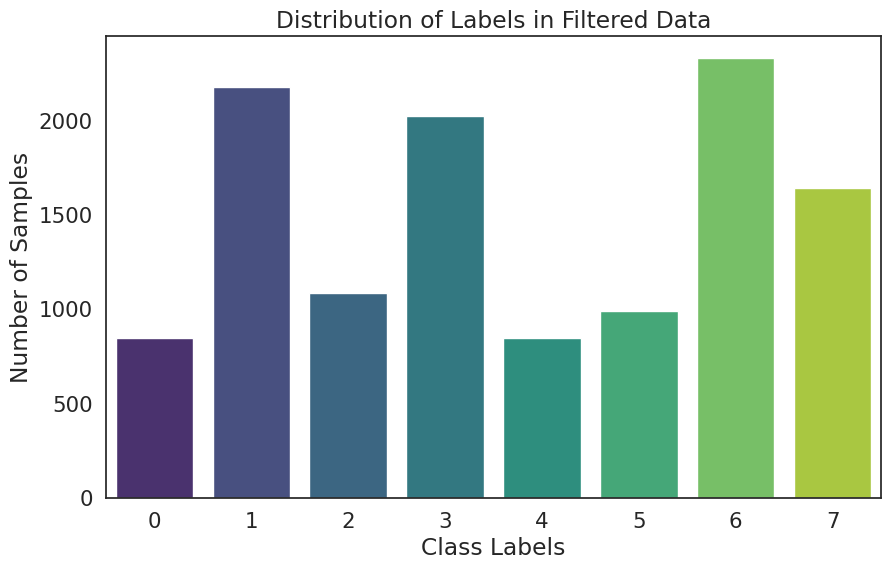

In [8]:
# Count the number of occurrences for each label in y
unique_labels, label_counts = np.unique(y_unique, return_counts=True)

# Plotting the label distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=unique_labels, y=label_counts, palette='viridis')

plt.title('Distribution of Labels in Filtered Data')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.xticks(unique_labels)
plt.show()

In [9]:
# keeping 80% for the training set and 20% for the validation
X_train, X_val, y_train, y_val = train_test_split(X_unique, y_unique, test_size=0.2, random_state=42)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)

Train: (9562, 96, 96, 3) (9562, 1)
Validation: (2391, 96, 96, 3) (2391, 1)


## Bilanciamento delle classi

In [10]:
# Flatten y_train to a 1D array before passing it to compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.ravel())
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print(class_weight_dict)

{0: 1.7919790104947526, 1: 0.6806662870159453, 2: 1.3898255813953488, 3: 0.7433146766169154, 4: 1.7525659824046922, 5: 1.505352644836272, 6: 0.6290789473684211, 7: 0.922972972972973}


In [11]:
# Convert labels to categorical format using one-hot encoding
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)

In [12]:
# Compare categorical label and "default" label representation
print('Categorical label:', y_train[0])
print('"Default" label:', np.argmax(y_train[0]))

Categorical label: [0. 0. 0. 1. 0. 0. 0. 0.]
"Default" label: 3


## Network Parameters

In [13]:
input_shape = (96,96,3) # input shape basta che sia multiplo di 32 per la SENet quindi lasciamo 96,96,3
output_shape = y_train.shape[1] # output shape of the model: 8 classi
print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

# it makes sense because the input shape is the dimension of the image and 3 channels
# and the output is 8 as the number of the possible classes

Input Shape: (96, 96, 3)
Output Shape: 8


In [14]:
epochs = 300 # epochs
batch_size = 64 # batch
learning_rate = 0.001 # step size for updating the model's weights

# Initialise configuration for convolutional layers
stack = 1 # solo un layer
filters = 32 # convolutional layers
kernel_size = 3

##Data Augmentation

In [15]:
augmentation_choosen = tf.keras.Sequential([
    tfkl.RandomZoom(0.2),  # Zoom leggero, circa 20%
    tfkl.RandomFlip('horizontal_and_vertical'),
    tfkl.RandomTranslation(0.2, 0.2),  # Traslazione 20%
    tfkl.RandomRotation(0.2),  # Rotazione fino a ±20°
    tfkl.RandomBrightness(0.2, value_range=(0, 1)),  # Luminosità con range limitato 0.8-1.2 per simulare diversi tipi di luminosità dei microscopi
    tfkl.RandomContrast(0.2),  # Contrasto, range 0.8-1.2 sempre per lo strumento ovvero il microscopio
], name='preprocessing')

In [16]:
# early stopping
patience = 200

early_stopping = tfk.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    mode = 'max',
    patience = patience,
    restore_best_weights = True
)

callbacks = [early_stopping]

## 🛠️ Train and Save the Model

keras_tensor_446: trainable=False
keras_tensor_447: trainable=False
keras_tensor_448: trainable=False
keras_tensor_449: trainable=False
keras_tensor_450: trainable=False
keras_tensor_451: trainable=False
keras_tensor_452: trainable=False
keras_tensor_453: trainable=False
keras_tensor_454: trainable=False
keras_tensor_455: trainable=False
keras_tensor_456: trainable=False
keras_tensor_457: trainable=False
keras_tensor_458: trainable=False
keras_tensor_459: trainable=False
keras_tensor_460: trainable=False
keras_tensor_461: trainable=False
keras_tensor_462: trainable=False
keras_tensor_463: trainable=False
keras_tensor_464: trainable=False
keras_tensor_466: trainable=False
keras_tensor_467: trainable=False
keras_tensor_468: trainable=False
keras_tensor_469: trainable=False
keras_tensor_470: trainable=False
keras_tensor_471: trainable=False
keras_tensor_472: trainable=False
keras_tensor_473: trainable=False
keras_tensor_474: trainable=False
keras_tensor_475: trainable=False
keras_tensor_4

Model: "architecture"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer (InputLayer)            │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ rescaling (Rescaling)               │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ gap (GlobalAveragePooling2D)        │ (None, 3)                    │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense1 (Dense)                      │ (None, 512)                  │         2,048 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout1 (Dropout)                  │ (None, 512)                  │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense2 (Dense)                      │ (None, 256)                  │       131,328 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout2 (Dropout)                  │ (None, 256)                  │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 8)                    │         2,056 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ softmax (Activation)                │ (None, 8)                    │             0 │    -    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 135,432 (529.03 KB)

 Trainable params: 135,432 (529.03 KB)

 Non-trainable params: 0 (0.00 B)

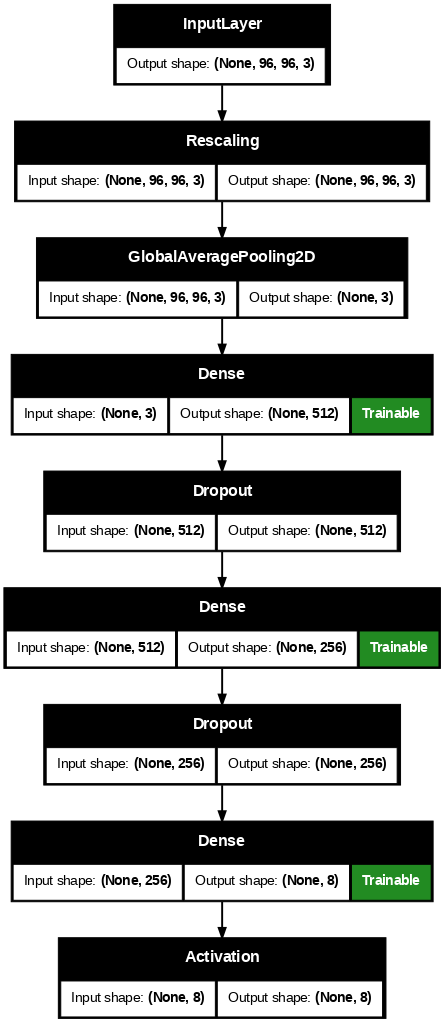

In [33]:
def inception_block_bn(x, filters, kernel_size=3, padding='same',
                       downsample=True, activation='relu', stack=2, name='inception'):
    INC_layers = []  # Lista per tracciare i layers della Inception

    for s in range(stack):
        # 1x1 Convolution Path
        path1 = tfkl.Conv2D(filters // 4, 1, padding=padding, name=f'{name}_conv1_{s}')(x)
        bn1 = tfkl.BatchNormalization(name=f'{name}_bn1_{s}')(path1)
        act1 = tfkl.Activation(activation, name=f'{name}_act1_{s}')(bn1)

        # 3x3 Convolution Path with Reduction
        path2_reduce = tfkl.Conv2D(filters // 8, 1, padding=padding, name=f'{name}_conv3_reduce_{s}')(x)
        bn2_reduce = tfkl.BatchNormalization(name=f'{name}_bn3_reduce_{s}')(path2_reduce)
        act2_reduce = tfkl.Activation(activation, name=f'{name}_act3_reduce_{s}')(bn2_reduce)
        path2 = tfkl.Conv2D(filters // 4, 3, padding=padding, name=f'{name}_conv3_{s}')(act2_reduce)
        bn2 = tfkl.BatchNormalization(name=f'{name}_bn3_{s}')(path2)
        act2 = tfkl.Activation(activation, name=f'{name}_act3_{s}')(bn2)

        # 5x5 Convolution Path with Reduction
        path3_reduce = tfkl.Conv2D(filters // 12, 1, padding=padding, name=f'{name}_conv5_reduce_{s}')(x)
        bn3_reduce = tfkl.BatchNormalization(name=f'{name}_bn5_reduce_{s}')(path3_reduce)
        act3_reduce = tfkl.Activation(activation, name=f'{name}_act5_reduce_{s}')(bn3_reduce)
        path3 = tfkl.Conv2D(filters // 4, 5, padding=padding, name=f'{name}_conv5_{s}')(act3_reduce)
        bn3 = tfkl.BatchNormalization(name=f'{name}_bn5_{s}')(path3)
        act3 = tfkl.Activation(activation, name=f'{name}_act5_{s}')(bn3)

        # Pooling Path
        path4 = tfkl.MaxPooling2D(3, strides=1, padding=padding, name=f'{name}_pooling_{s}')(x)
        proj4 = tfkl.Conv2D(filters // 4, 1, padding=padding, name=f'{name}_pool_proj_{s}')(path4)
        bn4 = tfkl.BatchNormalization(name=f'{name}_bn_pool_proj_{s}')(proj4)
        act4 = tfkl.Activation(activation, name=f'{name}_act_pool_proj_{s}')(bn4)

        # Concatenate all paths
        x = tfkl.Concatenate(name=f'{name}_concat_{s}')([act1, act2, act3, act4])

        # Track all layers in INC_layers
        INC_layers.extend([path1, bn1, act1, path2_reduce, bn2_reduce, act2_reduce,
                           path2, bn2, act2, path3_reduce, bn3_reduce, act3_reduce,
                           path3, bn3, act3, path4, proj4, bn4, act4])

    # Optional downsampling
    if downsample:
        x = tfkl.MaxPooling2D(2, name=f'{name}_pool')(x)
        INC_layers.append(x)

    return x, INC_layers

# Test the freezing mechanism
input_shape = (96, 96, 3)
filters = 64
stack = 2
output_shape = 8  # Number of classes

# Input layer
input_layer = tfkl.Input(shape=input_shape, name='input_layer')

# Inception Block
x = tfkl.Rescaling(1 / 255, name='rescaling')(input_layer)
x, INC_layers = inception_block_bn(x, filters, stack=stack, name="block0")

# Freeze layers explicitly
for layer in INC_layers:
    layer.trainable = False

# Verify freezing
for layer in INC_layers:
    print(f"{layer.name}: trainable={layer.trainable}")

# Augmentation
x = tfkl.Rescaling(1/255, name='rescaling')(input_layer)
x_augmented = augmentation_choosen(x)

# Global Average Pooling and Additional Layers
x = tfkl.GlobalAveragePooling2D(name='gap')(x)
x = tfkl.Dense(512, activation='relu', name='dense1')(x)
x = tfkl.Dropout(0.5, name='dropout1')(x)
x = tfkl.Dense(256, activation='relu', name='dense2')(x)
x = tfkl.Dropout(0.5, name='dropout2')(x)

# Output Layer
x = tfkl.Dense(output_shape, name='dense')(x)
x = tfkl.Activation('softmax', name='softmax')(x)

# Create and Compile the Model
model = tfk.Model(inputs=input_layer, outputs=x, name='architecture')
model.compile(
    loss=tfk.losses.CategoricalCrossentropy(),
    optimizer=tfk.optimizers.Adam(),
    metrics=['accuracy']
)

# Verify Freezing of Layers
print("\nTrainable Layers:")
for layer in model.layers:
    print(f"{layer.name}: {layer.trainable}")

# Display Model Summary and Plot
model.summary(expand_nested=True, show_trainable=True)
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

# Batch normalization layer con 8 parametri perchè abbiamo 2 channels
# schema di prima con aggiunti i batch normalization layers

In [34]:
# Train the model
history = model.fit(
    x=X_train * 255,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    class_weight=class_weight_dict,
    validation_data=(X_val * 255, y_val),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)] # restore serve per il best model
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model.save('weights.keras')

# Free memory by deleting the model instance
del model

Epoch 1/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.1758 - loss: 2.0156 - val_accuracy: 0.3860 - val_loss: 1.5801
Epoch 2/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3263 - loss: 1.6168 - val_accuracy: 0.4061 - val_loss: 1.4738
Epoch 3/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3442 - loss: 1.5589 - val_accuracy: 0.3961 - val_loss: 1.4568
Epoch 4/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3549 - loss: 1.5250 - val_accuracy: 0.4099 - val_loss: 1.4442
Epoch 5/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3556 - loss: 1.5172 - val_accuracy: 0.3927 - val_loss: 1.4490
Epoch 6/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3666 - loss: 1.5085 - val_accuracy: 0.4044 - val_loss: 1.4392
Epoch 7/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3696 - loss: 1.4860 - val_accuracy: 0.3944 - val_loss: 1.4362
Epoch 8/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3752 - loss: 1.4793 - val_acc

In [ ]:
# Inception Block - Final validation accuracy: 38.06%
# with one new dense leyer before the output - Final validation accuracy: 59.77%
# with two new dense layers - Final validation accuracy: 61.98%

In [35]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Writing model.py


In [36]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

from google.colab import files
files.download(filename)

  adding: model.py (deflated 56%)
  adding: weights.keras (deflated 36%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>